In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm

In [ ]:
"""def draw_data(N_data= 10000, N_BT = None, mu=[0,0], sigma=[[1,0],[0,1]]):
    if N_BT is None:
        N_BT=N_data
    data_data = np.random.multivariate_normal(mu, sigma, size=N_data)
    data_BT = np.random.multivariate_normal(mu, sigma, size=N_BT)
    data = np.concatenate((data_data, data_BT))
    labels = np.append(np.ones(N_data), np.zeros(N_BT))
    inds = np.arange(N_data+N_BT)
    np.random.shuffle(inds)
    data = data[inds]
    labels= labels[inds]
    return data, labels"""

def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

In [92]:
def sig(N, b, err):
    """
    Complicated significance formula calculation where N=N_obs, b = N_exp and err=delta_sys
    """
    if err==0:
        s=N-b
        #print(sum(b==0))
        #print(s/b)
        x=N*np.log(1+s/b)-s
        x[x<0]=0
        return np.sqrt(2*(x))
    s = N - b
    ln1 = N * (b+err**2) / (b**2+N*err**2)
    ln1 = 2 * N * np.log(ln1)

    ln2 = 1 + err**2 * s / b / (b+err**2)
    ln2 = 2 * b**2 / err**2 * np.log(ln2)
    x = ln1 - ln2
    x[x<0]=0
    return np.sqrt(x)

def significance_formula(N_data, N_BT):
    return sig(N_data, N_BT, 0)

In [112]:
N_tests = 10000
bins=5
N = 100000
sigs = np.zeros((bins*bins, N_tests))
rv = multivariate_normal([0,0], [[1,0],[0,1]])
_, edges = np.histogramdd(rv.rvs(size=100000), bins=bins)
exp = np.zeros((bins,bins))
for i in range(bins):
    for j in range(bins):
        exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N
exp = exp.flatten()
#print(exp)
for k in tqdm.tqdm(range(N_tests)):
    data = rv.rvs(size=N)
    hist = np.histogramdd(data, bins=edges)[0].flatten()
    #print(hist)
    sigs[:, k] = significance_formula(hist, exp)

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/zu992399/login23-3_167893/ipykernel_70239/3976211350.py:9: RuntimeWarning: divide by zero encountered in log
  x=N*np.log(1+s/b)-s
/tmp/zu992399/login23-3_167893/ipykernel_70239/3976211350.py:9: RuntimeWarning: invalid value encountered in multiply
  x=N*np.log(1+s/b)-s
100%|██████████| 10000/10000 [01:21<00:00, 121.98it/s]


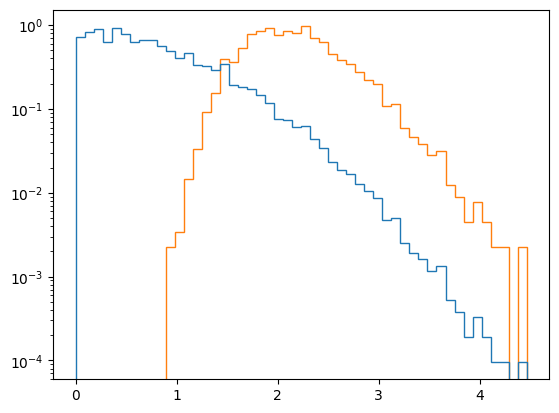

In [116]:
plt.figure()
plt.hist((sigs.flatten(), np.nanmax(sigs, axis=0)), bins=50, histtype="step", density=True)
plt.yscale("log")

(236916,)
236916
236916
0.0 0.04986155430616759
0.0 0.04986155430616759
(10000,)


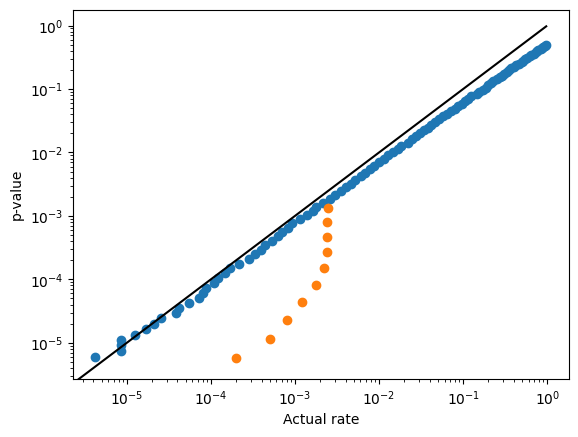

In [137]:
plt.figure()
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")
sig_use = sigs.flatten()
sig_use = sig_use[np.isfinite(sig_use)]
print(sig_use.shape)
print(len(sig_use))
#print(exp)
counts, edges = np.histogram(sig_use, bins=100)
print(sum(counts))
print(min(counts/len(sig_use)), max(counts/len(sig_use)))
x = [min(counts/len(sig_use)), max(counts/len(sig_use))]
#plt.plot(x, x, color="black")
counts_cumulative = np.array([sum(counts[::-1][:i]) for i in range(len(counts))])
print(min(counts/len(sig_use)), max(counts/len(sig_use)))
x = [min(counts_cumulative/len(sig_use)), max(counts_cumulative/len(sig_use))]
plt.plot(x, x, color="black")
edges = edges[::-1]
plt.scatter(counts_cumulative/len(sig_use),1-stats.norm.cdf(edges[1:]))
trials=bins*bins
print(np.nanmax(sigs, axis=0).shape)
counts_max, edges = np.histogram(np.nanmax(sigs, axis=1), bins=10)
counts_max_cumulative = np.array([sum(counts_max[i:]) for i in range(len(counts_max))])
edges = edges
plt.scatter(counts_max_cumulative/N_tests,(1-stats.norm.cdf((edges[1:]+edges[:-1])/2)))
